# Project 3 — Titanic Classification
**Name:** Brandon  
**Goal:** Compare DT, SVC, NN on 3 cases (alone | age | age+family_size) with stratified split.


In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score

plt.rcParams['figure.figsize'] = (8,6)



## Step 2 — Load and Inspect the Data
We’ll use Seaborn’s built-in Titanic dataset to preview and understand what columns we can work with.


In [2]:
import seaborn as sns
titanic = sns.load_dataset('titanic')
titanic.head()


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [3]:
titanic.info()
titanic.describe(include='all')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
count,891.000000,891.000000,891,714.000000,891.000000,891.000000,891.000000,889,891,891,891,203,889,891,891
unique,NaN,NaN,2,NaN,NaN,NaN,NaN,3,3,3,2,7,3,2,2
top,NaN,NaN,male,NaN,NaN,NaN,NaN,S,Third,man,True,C,Southampton,no,True
freq,NaN,NaN,577,NaN,NaN,NaN,NaN,644,491,537,537,59,644,549,537
mean,0.383838,2.308642,NaN,29.699118,0.523008,0.381594,32.204208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,0.486592,0.836071,NaN,14.526497,1.102743,0.806057,49.693429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,1.000000,NaN,0.420000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,0.000000,2.000000,NaN,20.125000,0.000000,0.000000,7.910400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,0.000000,3.000000,NaN,28.000000,0.000000,0.000000,14.454200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,1.000000,3.000000,NaN,38.000000,1.000000,0.000000,31.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Step 3 — Clean & Feature Engineer
- Impute `age` (median) and `embark_town` (mode)
- Create `family_size = sibsp + parch + 1`
- Convert `alone` to int (0/1) for modeling


In [4]:
# Impute missing values
titanic['age'] = titanic['age'].fillna(titanic['age'].median())
titanic['embark_town'] = titanic['embark_town'].fillna(titanic['embark_town'].mode()[0])

# Feature engineering
titanic['family_size'] = titanic['sibsp'] + titanic['parch'] + 1
titanic['alone'] = titanic['alone'].astype(int)

# Quick sanity checks
print("Null rates (top 10):")
print(titanic.isna().mean().sort_values(ascending=False).head(10))

titanic[['survived','age','embark_town','sibsp','parch','family_size','alone']].head()


Null rates (top 10):
deck        0.772166
embarked    0.002245
survived    0.000000
pclass      0.000000
sex         0.000000
age         0.000000
sibsp       0.000000
parch       0.000000
fare        0.000000
class       0.000000
dtype: float64


,survived,age,embark_town,sibsp,parch,family_size,alone
0,0,22.0,Southampton,1,0,2,0
1,1,38.0,Cherbourg,1,0,2,0
2,1,26.0,Southampton,0,0,1,1
3,1,35.0,Southampton,1,0,2,0
4,0,35.0,Southampton,0,0,1,1


In [5]:
# Case 1: feature = alone
X1 = titanic[['alone']]
y1 = titanic['survived']

# Case 2: feature = age (ensure no NaNs)
X2 = titanic[['age']].dropna()
y2 = titanic.loc[X2.index, 'survived']

# Case 3: features = age + family_size (ensure no NaNs)
X3 = titanic[['age','family_size']].dropna()
y3 = titanic.loc[X3.index, 'survived']

len(X1), len(X2), len(X3)


(891, 891, 891)

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

def stratified_split(X, y, test_size=0.2, seed=123):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)
    for tr_idx, te_idx in sss.split(X, y):
        return X.iloc[tr_idx], X.iloc[te_idx], y.iloc[tr_idx], y.iloc[te_idx]

X1_tr, X1_te, y1_tr, y1_te = stratified_split(X1, y1)
X2_tr, X2_te, y2_tr, y2_te = stratified_split(X2, y2)
X3_tr, X3_te, y3_tr, y3_te = stratified_split(X3, y3)

(len(X1_tr), len(X1_te)), (len(X2_tr), len(X2_te)), (len(X3_tr), len(X3_te))


((712, 179), (712, 179), (712, 179))

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

def run_dt(Xtr, ytr, Xte, yte, label):
    m = DecisionTreeClassifier()
    m.fit(Xtr, ytr)
    print(label)
    print(classification_report(yte, m.predict(Xte)))
    return m

dt1 = run_dt(X1_tr, y1_tr, X1_te, y1_te, "DT Case 1: alone")
dt2 = run_dt(X2_tr, y2_tr, X2_te, y2_te, "DT Case 2: age")
dt3 = run_dt(X3_tr, y3_tr, X3_te, y3_te, "DT Case 3: age+family_size")


DT Case 1: alone
              precision    recall  f1-score   support

           0       0.71      0.65      0.68       110
           1       0.51      0.58      0.54        69

    accuracy                           0.63       179
   macro avg       0.61      0.62      0.61       179
weighted avg       0.64      0.63      0.63       179

DT Case 2: age
              precision    recall  f1-score   support

           0       0.63      0.89      0.74       110
           1       0.50      0.17      0.26        69

    accuracy                           0.61       179
   macro avg       0.57      0.53      0.50       179
weighted avg       0.58      0.61      0.55       179

DT Case 3: age+family_size
              precision    recall  f1-score   support

           0       0.64      0.75      0.69       110
           1       0.45      0.33      0.38        69

    accuracy                           0.59       179
   macro avg       0.55      0.54      0.54       179
weighted avg   

In [8]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

svc1 = SVC()  # RBF default
svc1.fit(X1_tr, y1_tr)
print("SVC — Case 1 (alone)")
print(classification_report(y1_te, svc1.predict(X1_te)))

svc2 = SVC()
svc2.fit(X2_tr, y2_tr)
print("SVC — Case 2 (age)")
print(classification_report(y2_te, svc2.predict(X2_te)))

svc3 = SVC()
svc3.fit(X3_tr, y3_tr)
print("SVC — Case 3 (age + family_size)")
print(classification_report(y3_te, svc3.predict(X3_te)))


SVC — Case 1 (alone)
              precision    recall  f1-score   support

           0       0.71      0.65      0.68       110
           1       0.51      0.58      0.54        69

    accuracy                           0.63       179
   macro avg       0.61      0.62      0.61       179
weighted avg       0.64      0.63      0.63       179

SVC — Case 2 (age)
              precision    recall  f1-score   support

           0       0.63      0.98      0.77       110
           1       0.71      0.07      0.13        69

    accuracy                           0.63       179
   macro avg       0.67      0.53      0.45       179
weighted avg       0.66      0.63      0.52       179

SVC — Case 3 (age + family_size)
              precision    recall  f1-score   support

           0       0.63      0.98      0.77       110
           1       0.71      0.07      0.13        69

    accuracy                           0.63       179
   macro avg       0.67      0.53      0.45       179
w

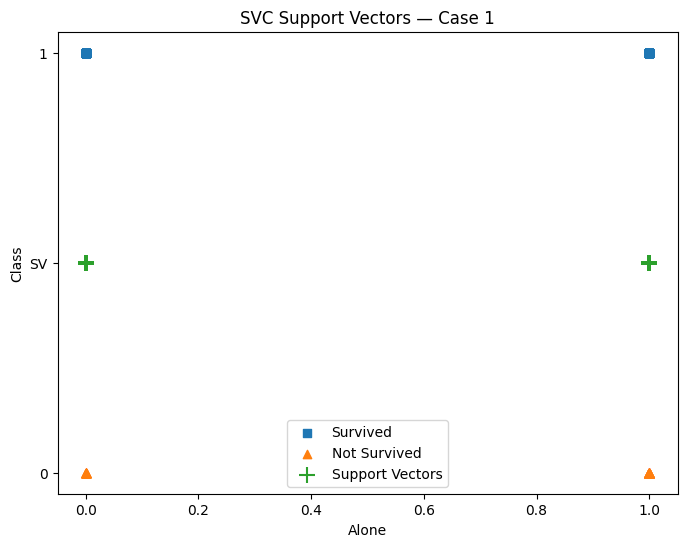

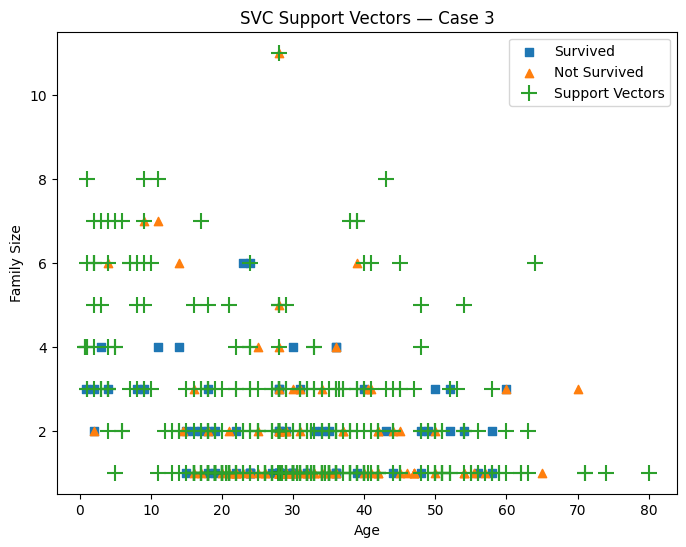

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Case 1 (1D): plot points at y=0/1 and support vectors at y=0.5
plt.figure()
plt.scatter(X1_te['alone'][y1_te==1], np.ones(sum(y1_te==1)), marker='s', label='Survived')
plt.scatter(X1_te['alone'][y1_te==0], np.zeros(sum(y1_te==0)), marker='^', label='Not Survived')

if hasattr(svc1, "support_vectors_"):
    svx = svc1.support_vectors_[:,0]
    plt.scatter(svx, np.full_like(svx, 0.5), marker='+', s=120, label='Support Vectors')

plt.yticks([0,0.5,1], ['0','SV','1'])
plt.xlabel('Alone'); plt.ylabel('Class'); plt.title('SVC Support Vectors — Case 1')
plt.legend(); plt.show()

# Case 3 (2D): age vs family_size with support vectors
plt.figure()
plt.scatter(X3_te['age'][y3_te==1], X3_te['family_size'][y3_te==1], marker='s', label='Survived')
plt.scatter(X3_te['age'][y3_te==0], X3_te['family_size'][y3_te==0], marker='^', label='Not Survived')

if hasattr(svc3, "support_vectors_"):
    sv = svc3.support_vectors_
    plt.scatter(sv[:,0], sv[:,1], marker='+', s=120, label='Support Vectors')

plt.xlabel('Age'); plt.ylabel('Family Size'); plt.title('SVC Support Vectors — Case 3')
plt.legend(); plt.show()


Neural Net — Case 3 (age + family_size)
              precision    recall  f1-score   support

           0       0.70      0.76      0.73       110
           1       0.56      0.48      0.52        69

    accuracy                           0.65       179
   macro avg       0.63      0.62      0.62       179
weighted avg       0.65      0.65      0.65       179



/Users/b/Repos/applied-ml-brandon/notebooks/project03/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:602: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


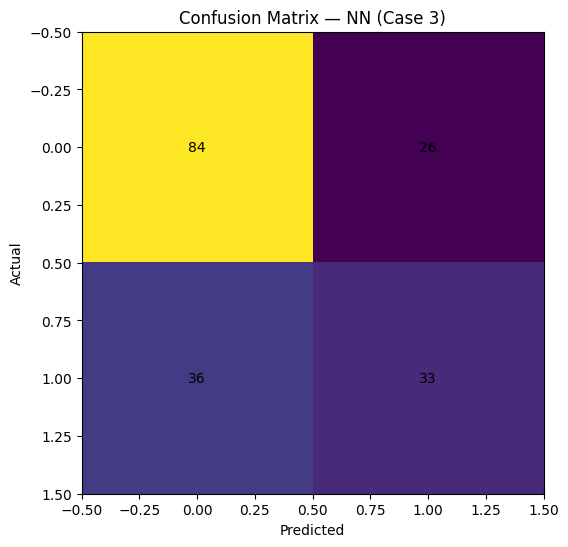

In [10]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

nn3 = MLPClassifier(hidden_layer_sizes=(50,25,10),
                    solver='lbfgs',
                    max_iter=1000,
                    random_state=42)
nn3.fit(X3_tr, y3_tr)

print("Neural Net — Case 3 (age + family_size)")
y3_nn_pred = nn3.predict(X3_te)
print(classification_report(y3_te, y3_nn_pred))

cm = confusion_matrix(y3_te, y3_nn_pred)
plt.imshow(cm)
plt.title("Confusion Matrix — NN (Case 3)")
plt.xlabel("Predicted"); plt.ylabel("Actual")
for (i,j),v in np.ndenumerate(cm):
    plt.text(j,i,str(v),ha='center',va='center')
plt.show()


/Users/b/Repos/applied-ml-brandon/notebooks/project03/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


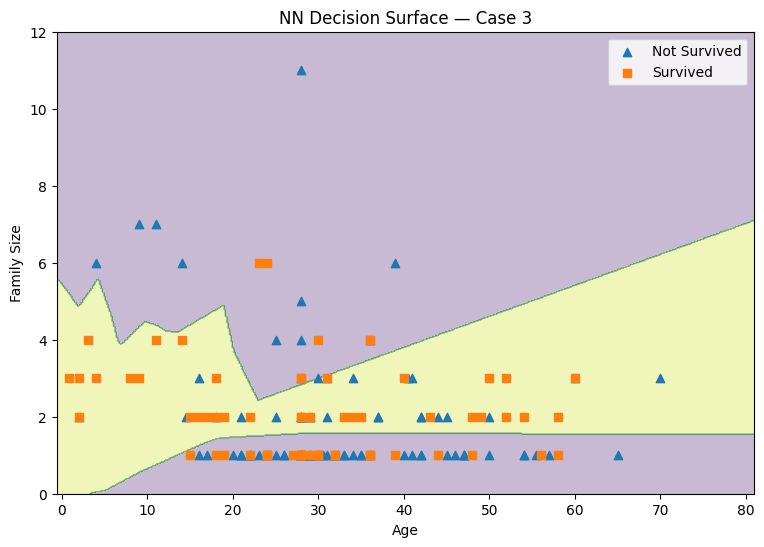

In [11]:
# Decision surface over age (x) and family_size (y)
x_min, x_max = X3['age'].min()-1, X3['age'].max()+1
y_min, y_max = X3['family_size'].min()-1, X3['family_size'].max()+1

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))
Z = nn3.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(9,6))
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X3_te['age'][y3_te==0], X3_te['family_size'][y3_te==0], marker='^', label='Not Survived')
plt.scatter(X3_te['age'][y3_te==1], X3_te['family_size'][y3_te==1], marker='s', label='Survived')
plt.xlabel('Age'); plt.ylabel('Family Size'); plt.title('NN Decision Surface — Case 3')
plt.legend(); plt.show()
